In [3]:
import os, glob, sys, math, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
import StructureTools
import CV
import freesasa
import joblib

Ci-dessous l'analyse des complexes en termes de :

1. Calculer SASA et rSASA pour identifier la surface (rSASA > .25) et l'interface (dSASA > 0)
2. Calculer la CV des résidus à la surface et à l'interface
3. Calculer la fréquence des 20 aa à la surface et à l'interface
4. Calculer la taille de la surface et de l'interface par monomère (en termes de nombre de résidus et de SASA en $ Å^2$).

Pour un aperçu des résultats, voir [Section 2](#Aperçu).

# Analyse

In [4]:
####################
# deal paths
#-------------------
treated_family = "kihara"

cplxpath = "../structures/%s/complexes/"%(treated_family)
monopath = "../structures/%s/monomers/"%(treated_family)
print(cplxpath)
print("%s complexes to treat"%(len(os.listdir(cplxpath))))
print(os.listdir(cplxpath))
print(monopath)
print("%s monomers to treat"%(len(os.listdir(monopath))))
print(os.listdir(monopath))

../structures/kihara/complexes/
67 complexes to treat
['t1F6M_AC_cplx.pdb', 't1GCQ_AC_cplx.pdb', 't1I4D_AD_cplx.pdb', 'p1AY7_AB_cplx.pdb', 'p1UUG_AB_cplx.pdb', 'p1EMV_AB_cplx.pdb', 'p2OUL_AB_cplx.pdb', 'p2OZA_AB_cplx.pdb', 't1LFD_AB_cplx.pdb', 'p2SNI_EI_cplx.pdb', 'p1EER_AB_cplx.pdb', 'p1BVN_PT_cplx.pdb', 'p1WDW_AB_cplx.pdb', 'p1GXD_AC_cplx.pdb', 'p2O3B_AB_cplx.pdb', 't1Z0K_AB_cplx.pdb', 't1A15_AB_cplx.pdb', 't1EWY_AC_cplx.pdb', 'p1OPH_AB_cplx.pdb', 'p1M10_AB_cplx.pdb', 'p1AVX_AB_cplx.pdb', 'p3SGB_EI_cplx.pdb', 't1FFW_AB_cplx.pdb', 'p1JTG_AB_cplx.pdb', 't1HE8_AB_cplx.pdb', 'p2BTF_AP_cplx.pdb', 'p1JIW_IP_cplx.pdb', 't2TGP_IZ_cplx.pdb', 'p1T6B_XY_cplx.pdb', 't1US7_BA_cplx.pdb', 't1S1Q_AB_cplx.pdb', 'p1DFJ_EI_cplx.pdb', 'p1BRS_AD_cplx.pdb', 'p1PXV_AC_cplx.pdb', 'p2J0T_AD_cplx.pdb', 'p1PPE_EI_cplx.pdb', 't1A78_AB_cplx.pdb', 't1QA9_AB_cplx.pdb', 't1J2J_AB_cplx.pdb', 't1WQ1_RG_cplx.pdb', 'p1ATN_DA_cplx.pdb', 'p1GPW_AB_cplx.pdb', 'p2GOX_AB_cplx.pdb', 't2FJU_AB_cplx.pdb', 'p1NB5_AI_cplx.pdb', 

In [11]:
def multipleKStest(l1, l2):
    pvalues = []
    for i in range(1000) :
        
        pvalues.append(kstest(random.sample(l1, k = 200), random.sample(l2, k = 200)).pvalue)
    
    return sum(pvalues)/len(pvalues)

In [12]:
def writeDistribValues(listowrite, flagtowrite):
    """write the values in the list in a text file (1 col) -> output name is defined according to flagtowrite """
    fout = open("%s.txt"%(flagtowrite),"w")
    for val in listowrite:
        fout.write("%s\n"%(val))
        
    fout.close()

## Calculate SASA and define surface/interface

In [13]:
############################################################################@
#
#           Identification of interface and surface residues
#
############################################################################@

def assignChainsToLigAndRec(dASAcp, dASAlig, dASArec):
    """assign each chain of the complex to the lig or rec dict"""
        
    for chncp in dASAcp :
        if chncp in dASAlig: # means the first chain is the ligand
            first = "lig"
            second = "rec"
            return first, second
        else:
            first = "rec"
            second = "lig"
            return first, second
                

In [14]:
def getSurfRes(dASAcp, dASAlig, dASArec):
    """extract surface residues through the comparison of their ASA in the monomer VS complex"""
        
    #init var
    ligsurf = []
    liginter = []
    recsurf = []
    recinter = []
    flag = 0
        
    # assign each chain of the complex to the lig or rec dict
    firstchain, secondchain = assignChainsToLigAndRec(dASAcp, dASAlig, dASArec)
    print("firstchain %s secondchain %s "%(firstchain, secondchain))     
    monostatus = firstchain
    
    for chncp in dASAcp :
        #print("curchain %s"%(chncp))
                            
        for rescp in dASAcp[chncp] :
                
            if monostatus == "lig" : #means the current chain is the lig
                        
                dASA = dASAlig[chncp][str(rescp)].relativeTotal - dASAcp[chncp][str(rescp)].relativeTotal
                    
                if dASA > 0 : # means the ASA in the lig is greater than in the cplx form, so the res is buried in the interface
                        
                    liginter.append(rescp)
                    ligsurf.append(rescp)
                else:
                    if dASAlig[chncp][str(rescp)].relativeTotal > 0.25 : # means the res is located on the lig surface
                        ligsurf.append(rescp)
            else :
                #print("dASARec.keys() %s"%(dASArec.keys()))
                #print("rescp %s "%(rescp))
                #print(dASArec["A"]["5"])
                dASA = dASArec[chncp][str(rescp)].relativeTotal - dASAcp[chncp][str(rescp)].relativeTotal
                    
                if dASA > 0 : # means the ASA in the lig is greater than in the cplx form, so the res is buried in the interface
                        
                    recinter.append(rescp)
                    recsurf.append(rescp)
                else:
                    if dASArec[chncp][str(rescp)].relativeTotal > 0.25 : # means the res is located on the lig surface
                        recsurf.append(rescp)
                    
                    
        # get status of second chain (contained in secondchain)          
        monostatus = secondchain
            
    return recsurf, ligsurf, recinter, liginter


In [15]:
#compute SASA of each mono and cplx

dico_inter_surf = {}
cv_intertmp = []
cv_surftmp = []

for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # init dico for this complex
    dico_inter_surf[rootname] = {}
    dico_inter_surf[rootname]["lig"] = {}
    dico_inter_surf[rootname]["rec"] = {}
    
    # compute SASA for the cplx
    strcplx = freesasa.Structure("%s/%s"%(cplxpath, cp))
    outASAcplx = freesasa.calc(strcplx)
    dASAcp = outASAcplx.residueAreas()
    
    # compute SASA for the lig
    strlig = freesasa.Structure("%s/%s"%(monopath, monol))
    outASAlig = freesasa.calc(strlig)
    dASAlig = outASAlig.residueAreas()
    
    # compute SASA for the lig
    strrec = freesasa.Structure("%s/%s"%(monopath, monor))
    outASArec = freesasa.calc(strrec)
    dASArec = outASArec.residueAreas()

    recsurf, ligsurf, recinter, liginter = getSurfRes(dASAcp, dASAlig, dASArec)

    dico_inter_surf[rootname]["lig"]["surf"] = ligsurf 
    dico_inter_surf[rootname]["lig"]["inter"] = liginter
    dico_inter_surf[rootname]["rec"]["surf"] = recsurf
    dico_inter_surf[rootname]["rec"]["inter"] = recinter 

    #print("list of interface residues in REC")
    #print(recinter)
    #print("list of interface residues in LIG")
    #print(liginter)


dealing with t1F6M_AC 
 t1F6M_AC_r_inter.pdb \t1F6M_AC_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1GCQ_AC 
 t1GCQ_AC_r_inter.pdb \t1GCQ_AC_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1I4D_AD 
 t1I4D_AD_r_inter.pdb \t1I4D_AD_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1AY7_AB 
 p1AY7_AB_r_inter.pdb \p1AY7_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1UUG_AB 
 p1UUG_AB_r_inter.pdb \p1UUG_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p1EMV_AB 
 p1EMV_AB_r_inter.pdb \p1EMV_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with p2OUL_AB 
 p2OUL_AB_r_inter.pdb \p2OUL_AB_l_inter.pdb
firstchain rec secondchain lig 
dealing with p2OZA_AB 
 p2OZA_AB_r_inter.pdb \p2OZA_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with t1LFD_AB 
 t1LFD_AB_r_inter.pdb \t1LFD_AB_l_inter.pdb
firstchain lig secondchain rec 
dealing with p2SNI_EI 
 p2SNI_EI_r_inter.pdb \p2SNI_EI_l_inter.pdb
firstchain rec secondchain lig 
dealing wi

In [125]:
# Store the dict to file
joblib.dump(dico_inter_surf, "../analysis/dico_inter_surf_{}.job".format(treated_family))

['../analysis/dico_inter_surf_kihara.job']

## CV

In [23]:
############################################################################@
#
#                        Calculation of CV
#
############################################################################@

def getCV_fromResList(d_pdb, chainID, reslist):
    
    cv = []
    
    for resi in d_pdb[chainID]["reslist"] :
        if reslist is None or resi in reslist :
            firstatom = d_pdb[chainID][resi]["atomlist"][0] # get the first atom and then the corresponding cv since the CV is identical for all atoms
            cv.append(d_pdb[chainID][resi][firstatom]["bfactor"])
            
    return cv

In [24]:
# calculation of the CV of each residue of each monomer with the CV module
#--------------------------------------------------------------------------

#init var
rc = 8 #radius for CV calculation
cv_intertmp = []
cv_surftmp = []

# compute res CV for each monomer
for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig, atomlistlig = StructureTools.PDB_parser("%s/%s"%(monopath, monol), returnatomlist=True)
    #print(d_pdblig["chains"])
    chainlig = d_pdblig["chains"][0]
    d_pdbrec, atomlistrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor), returnatomlist=True)
    chainrec = d_pdbrec["chains"][0]

    # calcule la variance variance circulaire de chq atome --> returns the average per residue
    CV.CV_AllRes(atomlistlig, d_pdblig, chainlig, rc)
    CV.CV_AllRes(atomlistrec, d_pdbrec, chainrec, rc)

    # get CV for all res of the interface
    cv_intertmp.append(getCV_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["inter"]))
    cv_intertmp.append(getCV_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["inter"]))

    # get CV for all res of the surface
    cv_surftmp.append(getCV_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["surf"]))
    cv_surftmp.append(getCV_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["surf"]))

    
# store CV
cv_inter = [cv for cvlist in cv_intertmp for cv in cvlist]
cv_surf = [cv for cvlist in cv_surftmp for cv in cvlist]


dealing with t1F6M_AC 
 t1F6M_AC_r_inter.pdb \t1F6M_AC_l_inter.pdb
dealing with t1GCQ_AC 
 t1GCQ_AC_r_inter.pdb \t1GCQ_AC_l_inter.pdb
dealing with t1I4D_AD 
 t1I4D_AD_r_inter.pdb \t1I4D_AD_l_inter.pdb
dealing with p1AY7_AB 
 p1AY7_AB_r_inter.pdb \p1AY7_AB_l_inter.pdb
dealing with p1UUG_AB 
 p1UUG_AB_r_inter.pdb \p1UUG_AB_l_inter.pdb
dealing with p1EMV_AB 
 p1EMV_AB_r_inter.pdb \p1EMV_AB_l_inter.pdb
dealing with p2OUL_AB 
 p2OUL_AB_r_inter.pdb \p2OUL_AB_l_inter.pdb
dealing with p2OZA_AB 
 p2OZA_AB_r_inter.pdb \p2OZA_AB_l_inter.pdb
dealing with t1LFD_AB 
 t1LFD_AB_r_inter.pdb \t1LFD_AB_l_inter.pdb
dealing with p2SNI_EI 
 p2SNI_EI_r_inter.pdb \p2SNI_EI_l_inter.pdb
dealing with p1EER_AB 
 p1EER_AB_r_inter.pdb \p1EER_AB_l_inter.pdb
dealing with p1BVN_PT 
 p1BVN_PT_r_inter.pdb \p1BVN_PT_l_inter.pdb
dealing with p1WDW_AB 
 p1WDW_AB_r_inter.pdb \p1WDW_AB_l_inter.pdb
dealing with p1GXD_AC 
 p1GXD_AC_r_inter.pdb \p1GXD_AC_l_inter.pdb
dealing with p2O3B_AB 
 p2O3B_AB_r_inter.pdb \p2O3B_AB_l_inter

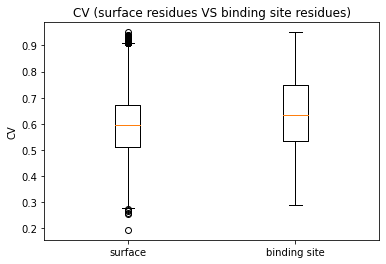

In [25]:
# plot CV distributions for surface and interface residues
#---------------------------------------------------------
fig1, ax1 = plt.subplots()
ax1.set_title('CV (surface residues VS binding site residues)')
ax1.boxplot([cv_surf, cv_inter])
plt.xticks([1, 2], ['surface', 'binding site']);
plt.ylabel("CV")
plt.savefig("CV_surf_vs_BS_%s.png"%(treated_family))

In [26]:
# write values in files
writeDistribValues(cv_surf, "CV_surf_%s"%(treated_family))
writeDistribValues(cv_inter, "CV_inter_%s"%(treated_family))


In [27]:
# KS test (2-sided) for CV between surf and interface residues
pval = multipleKStest(cv_surf, cv_inter)
print(pval)
kstest(cv_surf, cv_inter)


0.008066584230355688


KstestResult(statistic=0.17711900725281537, pvalue=1.4505142345554514e-83)

## Propensities

In [24]:
############################################################################@
#
#           Calculation of amino acid propensities for being in interfaces
#
############################################################################@


def compFreqAA_fromResList(d_pdb, chainID, reslist, d_aa):
    
    d_aa_tmp = {"ALA" : 0, "CYS" : 0, "ASP" : 0, "GLU" : 0, "PHE" : 0, "GLY" : 0, "HIS" : 0, "ILE" : 0, "LYS" : 0, "LEU" : 0, "MET" : 0, "ASN" : 0, "PRO" : 0, "GLN" : 0, "ARG" : 0, "SER" : 0, "THR" : 0, "VAL" : 0, "TRP" : 0, "TYR" : 0}
 
    # count the nb of each aa 
    for resi in d_pdb[chainID]["reslist"] :
        if resi in reslist :
            aa = d_pdb[chainID][resi]["resname"]
            d_aa_tmp[aa] +=1
    
    # normalize with the size of studied area (e.g. interface or surface) and store the result in d_aa
    for aa in d_aa_tmp :
        d_aa_tmp[aa] = d_aa_tmp[aa]/len(reslist)
        d_aa[aa].append(d_aa_tmp[aa])
        
    

In [25]:
# calculation of the aa freq in interfaces and surfaces, then calculation of the resulting propensities
#-------------------------------------------------------------------------------------------------------

#init var
d_aa_surf_cmt = {"ALA" : [], "CYS" : [], "ASP" : [], "GLU" : [], "PHE" : [], "GLY" : [], "HIS" : [], "ILE" : [], "LYS" : [], "LEU" : [], "MET" : [], "ASN" : [], "PRO" : [], "GLN" : [], "ARG" : [], "SER" : [], "THR" : [], "VAL" : [], "TRP" : [], "TYR" : []}
d_aa_inter_cmt = {"ALA" : [], "CYS" : [], "ASP" : [], "GLU" : [], "PHE" : [], "GLY" : [], "HIS" : [], "ILE" : [], "LYS" : [], "LEU" : [], "MET" : [], "ASN" : [], "PRO" : [], "GLN" : [], "ARG" : [], "SER" : [], "THR" : [], "VAL" : [], "TRP" : [], "TYR" : []}

# compute res CV for each monomer
for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]

    # compute the freq of each aa for inter and surf
    compFreqAA_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["inter"], d_aa_inter_cmt)
    compFreqAA_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["inter"], d_aa_inter_cmt)
    compFreqAA_fromResList(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["surf"], d_aa_surf_cmt)
    compFreqAA_fromResList(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["surf"], d_aa_surf_cmt)
    
# compute propension for being located at interfaces (i.e. stickiness)
d_prop_aa = {}
for aa in d_aa_inter_cmt :
    
    d_prop_aa[aa] = math.log2(np.mean(d_aa_inter_cmt[aa])/np.mean(d_aa_surf_cmt[aa]))
    



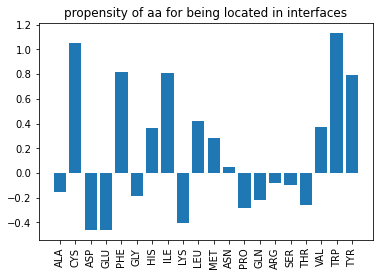

In [26]:
#  plot aa propensities
#----------------------

aaprop = []
aanames = []

xx = range(20)

for i in  d_prop_aa :
    aaprop.append(d_prop_aa[i])
    aanames.append(i)
    
plt.bar(xx, aaprop)
plt.title("propensity of aa for being located in interfaces")
plt.xticks(range(20), aanames, rotation = 90);
plt.savefig("aa_propensities_%s.png"%(treated_family))

In [14]:
# write values in files
writeDistribValues(aaprop, "aaprop_%s"%(treated_family))


In [15]:
############################################################################@###########@
#
#           Calculation of hydrophobic vs hydrophilic residue frequencies in interfaces
#
############################################################################@###########@
def compNB_HB_POL(d_pdb, chainID, reslist, d_HBPOL):
    
    HB = ["VAL","ILE","LEU","MET","TYR","PHE","TRP"]
    CHG = ["ARG","LYS","GLU","ASP"] # et HIS ???
    POL = ["SER","THR","ASN","GLN"]
    
    d_tmp = {"CHG": 0, "POL" : 0, "HB" : 0}
    
    # count the nb of each aa 
    for resi in d_pdb[chainID]["reslist"] :
        if resi in reslist :
            aa = d_pdb[chainID][resi]["resname"]
            if aa in HB :
                d_tmp["HB"] +=1
            elif aa in POL :
                d_tmp["POL"] +=1
            elif aa in CHG :
                d_tmp["CHG"] +=1
            
    
    # normalize with the size of studied area (e.g. interface or surface) and store the result in d_aa
    for aatype in d_tmp :
        d_tmp[aatype] = d_tmp[aatype]/len(reslist)
        d_HBPOL[aatype].append(d_tmp[aatype])
        

        
# calculation of the aa freq in interfaces and surfaces, then calculation of the resulting propensities
#-------------------------------------------------------------------------------------------------------

#init var
d_HBPOLsurf = {}
d_HBPOLsurf["HB"] = []
d_HBPOLsurf["POL"] = []
d_HBPOLsurf["CHG"] = []
d_HBPOLinter = {}
d_HBPOLinter["HB"] = []
d_HBPOLinter["POL"] = []
d_HBPOLinter["CHG"] = []



# compute res CV for each monomer
for cp in os.listdir(cplxpath) :
    

    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]

    # compute the freq of each aa for inter and surf
    compNB_HB_POL(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["inter"], d_HBPOLinter)
    compNB_HB_POL(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["inter"], d_HBPOLinter)
    compNB_HB_POL(d_pdblig, chainlig, dico_inter_surf[rootname]["lig"]["surf"], d_HBPOLsurf)
    compNB_HB_POL(d_pdbrec, chainrec, dico_inter_surf[rootname]["rec"]["surf"], d_HBPOLsurf)
    
    


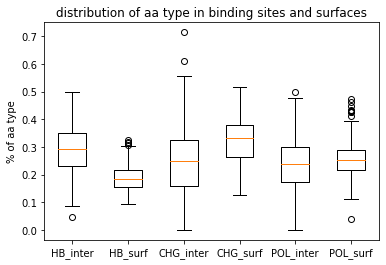

In [16]:
# plot CV distributions for surface and interface residues
#---------------------------------------------------------
fig1, ax1 = plt.subplots()
ax1.set_title('distribution of aa type in binding sites and surfaces')
ax1.boxplot([d_HBPOLinter["HB"], d_HBPOLsurf["HB"], d_HBPOLinter["CHG"], d_HBPOLsurf["CHG"], d_HBPOLinter["POL"], d_HBPOLsurf["POL"]])
plt.xticks(range(1,7), ['HB_inter', 'HB_surf', 'CHG_inter', 'CHG_surf', 'POL_inter', 'POL_surf']);
plt.ylabel("% of aa type")
plt.savefig("HB_POL_CHG_surf_vs_BS_%s.png"%(treated_family))

In [17]:
# write values in files
writeDistribValues(d_HBPOLsurf["HB"], "HB_surf_%s"%(treated_family))
writeDistribValues(d_HBPOLinter["HB"], "HB_inter_%s"%(treated_family))
writeDistribValues(d_HBPOLsurf["CHG"], "CHG_surf_%s"%(treated_family))
writeDistribValues(d_HBPOLinter["CHG"], "CHG_inter_%s"%(treated_family))
writeDistribValues(d_HBPOLsurf["POL"], "POL_surf_%s"%(treated_family))
writeDistribValues(d_HBPOLinter["POL"], "POL_inter_%s"%(treated_family))

## Sizes

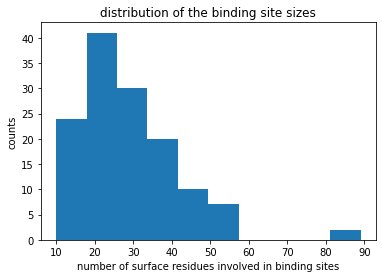

In [19]:
############################################################################@
#
#           Plot of the distribution of interface sizes
#
############################################################################@


# get interface sizes
sizes =[]
for cplx in dico_inter_surf :
    sizes.append(len(dico_inter_surf[cplx]["lig"]["inter"]))
    sizes.append(len(dico_inter_surf[cplx]["rec"]["inter"]))

    #s = [len(dico_inter_surf[x]["lig"]["surf"]) for x in dico_inter_surf]
# plot the size distribution
plt.hist(sizes, 10);
plt.title("distribution of the binding site sizes")
plt.xlabel("number of surface residues involved in binding sites")
plt.ylabel("counts")
plt.savefig("bindingSiteSizes_distrib_%s.png"%(treated_family))

In [20]:
# write values in file
writeDistribValues(sizes, "sizes_%s"%(treated_family))


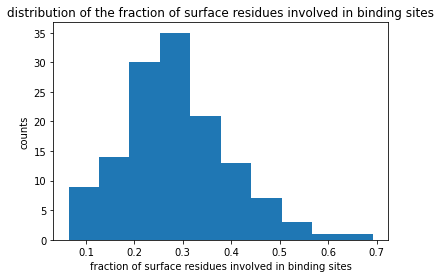

In [21]:
############################################################################@##########@
#
#           Plot of the distribution of interface sizes normalized by the surface size
#
############################################################################@##########@


# get interface sizes
sizes_norm =[]
for cplx in dico_inter_surf :
    sizes_norm.append(len(dico_inter_surf[cplx]["lig"]["inter"])/len(dico_inter_surf[cplx]["lig"]["surf"]))
    sizes_norm.append(len(dico_inter_surf[cplx]["rec"]["inter"])/len(dico_inter_surf[cplx]["rec"]["surf"]))

    #s = [len(dico_inter_surf[x]["lig"]["surf"]) for x in dico_inter_surf]
# plot the size distribution
plt.hist(sizes_norm);
plt.title("distribution of the fraction of surface residues involved in binding sites")
plt.xlabel("fraction of surface residues involved in binding sites")
plt.ylabel("counts")
plt.savefig("bindingSiteFraction_distrib_%s.png"%(treated_family))

In [22]:
# write values in file
writeDistribValues(sizes_norm, "norm_sizes_%s"%(treated_family))


## Total sizes

In [45]:
total_sizes = {}
# compute total size
for cp in os.listdir(cplxpath) :
    # store cplx and monomer names
    if cp.endswith(".pdb"):
        rootname = cp[:cp.rindex("_")]
    else:
        continue
    monor = rootname + "_r_inter.pdb"
    monol = rootname + "_l_inter.pdb"
    #print("dealing with %s \n %s \%s"%(rootname, monor, monol))

    # parse PDB    
    d_pdblig = StructureTools.PDB_parser("%s/%s"%(monopath, monol))
    chainlig = d_pdblig["chains"][0]
    d_pdbrec = StructureTools.PDB_parser("%s/%s"%(monopath, monor))
    chainrec = d_pdbrec["chains"][0]
    total_sizes[rootname] = dict(
        lig = len(d_pdblig[chainlig]['reslist']),
        rec = len(d_pdbrec[chainrec]['reslist'])
    )


## Create big table
Cette section pour usage interne. Creation d'un tableau et ecriture à fichier.

In [123]:
import pandas as pd

In [129]:
full_list = pd.DataFrame.from_dict(total_sizes).transpose()
full_list.loc[:, "tot"] = full_list.apply(lambda row: row.rec + row.lig, axis=1)
inter_sizes = zip(*[(sizes[i],sizes[i+1]) for i in range(0, len(sizes), 2)])
full_list.loc[:, "inter_lig"] = next(inter_sizes)
full_list.loc[:, "inter_rec"] = next(inter_sizes)
full_list.loc[:, "type"] = full_list.apply(lambda row: row.name[0], axis=1)
full_list.index = list(map(lambda s: s[1:], full_list.index.values))
full_list = full_list.sort_values(by=["tot", "type"]).reset_index()
full_list.columns = "PDB_chains size_lig size_rec size_tot inter_lig inter_rec type".split()

In [92]:
# GET COMPND
def get_pdb_line(fname, head="COMPND"):
    retstr = ""
    with open(fname) as pdbf:
        for l in pdbf:
            if l.startswith(head):
                retstr += " " + l[10:].strip()
    return retstr
    
full_list.loc[:, "description"] = ""
for i, cp in full_list.iterrows():
    fname = "../structures/{}/raw_pdb/{}{}.pdb1".format(
        treated_family, cp.type, cp.PDB_chains[:-3])
    try:
        descr = get_pdb_line(fname)
        if descr.strip() == "":
            descr = get_pdb_line(fname, "TITLE")
        full_list.loc[i, "description"] = descr
    except Exception as e:
        print(fname)
        pass        
        

In [94]:
full_list.to_csv('../analysis/{}.csv'.format(treated_family), sep='\t')

# Aperçu
Cette section à usage interne. Lecture des tableaux de données et visualisation des complexes.

In [1]:
import pandas as pd
import nglview as nv

In [5]:
full_list = pd.read_csv('../analysis/{}.csv'.format(treated_family), sep='\t', index_col='idx')

In [6]:
dico_inter_surf = joblib.load("../analysis/dico_inter_surf_{}.job".format(treated_family))

In [7]:
def _color_by_type(s):
    return ['background-color: '+x for x in ['bisque' if s.type == "t" else 'azure' for val in s]]

with pd.option_context('display.max_rows', None):
    display(full_list.style.apply(_color_by_type, axis=1))

,PDB_chains,size_lig,size_rec,size_tot,inter_lig,inter_rec,type,description
idx,,,,,,,,
0,2OOB_BA,44,72,116,11,14,t,"E3 ubiquitin-protein ligase CBL-B (E.C.6.3.2.-), Ubiquitin"
1,1CDT_AB,60,60,120,14,16,p,CARDIOTOXIN V4/II FROM NAJA MOSSAMBICA MOSSAMBICA: THE REFINED CRYSTAL STRUCTURE
2,1A15_AB,57,67,124,22,18,t,STROMAL DERIVED FACTOR-1ALPHA
3,1GCQ_AC,69,56,125,12,11,t,VAV AND GRB2 SH3 DOMAINS
4,1AY7_AB,89,96,185,17,19,p,"GUANYL-SPECIFIC RIBONUCLEASE SA, BARSTAR"
5,1BRS_AD,87,108,195,20,23,p,PROTEIN-PROTEIN RECOGNITION: CRYSTAL STRUCTURAL ANALYSIS OF A BARNASE- BARSTAR COMPLEX AT 2.0-A RESOLUTION
6,1FFW_AB,68,128,196,16,14,t,CHEY-BINDING DOMAIN OF CHEA IN COMPLEX WITH CHEY WITH A BOUND IMIDO DIPHOSPHATE
7,1QA9_AB,95,102,197,18,21,t,HUMAN CD2-CD58 Complex
8,1J2J_AB,41,165,206,16,18,t,ADP-ribosylation factor 1/ADP-ribosylation factor binding protein GGA1


In [8]:
open("../analysis/{}.html".format(treated_family), 'w').write(full_list.style.apply(_color_by_type, axis=1).render())

104580

In [140]:
## LOOK FOR NON-CANONICAL RESIDUES
canonical = ["VAL","ILE","LEU","MET","TYR","PHE","TRP",
             "ARG","LYS","GLU","ASP",
             "SER","THR","ASN","GLN",
             "HIS",
             "ALA","CYS","GLY","PRO"]

def scream_non_canonical(pdblig):
    for chain in pdblig['chains']:
        for resi in pdblig[chain]['reslist']:
            if pdblig[chain][resi]['resname'] not in canonical:
                print("ARGH {} not canonical".format(pdblig[chain][resi]['resname']))

for i, row in full_list.iterrows():
    pdbname = row.type + row.PDB_chains
    rootname = "../structures/{}/monomers/{}".format(treated_family, pdbname)
    ligname = rootname+"_l_inter.pdb"
    recname = rootname+"_r_inter.pdb"
    scream_non_canonical(StructureTools.PDB_parser(ligname))
    scream_non_canonical(StructureTools.PDB_parser(recname))
    

In [9]:
def show_complex(row):
    pdbname = row.type + row.PDB_chains
    rootname = "../structures/{}/monomers/{}".format(treated_family, pdbname)
    ligname = rootname+"_l_inter.pdb"
    recname = rootname+"_r_inter.pdb"
    v = nv.NGLWidget()
    v.add_component(ligname)
    v.add_component(recname)
    v.component_0.add_representation("ball+stick", " ".join(dico_inter_surf[pdbname]["lig"]["inter"]))
    v.component_1.add_representation("ball+stick", " ".join(dico_inter_surf[pdbname]["rec"]["inter"]))
    return(v)
def show_complex_helper(i):
    v = show_complex(full_list.iloc[i, :])
    display(full_list.iloc[i, :].PDB_chains + ":" + full_list.iloc[i, :].description)
    display(v)

In [10]:
show_complex_helper(11)

'3SGB_EI: STRUCTURE OF THE COMPLEX OF STREPTOMYCES GRISEUS PROTEASE B AND THE THIRD DOMAIN OF THE TURKEY OVOMUCOID INHIBITOR AT 1.8 ANGSTROMS RESOLUTION'

NGLWidget()